In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import cv2 # pip install opencv-python

In [2]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=784):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [3]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [4]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
num_features = 8
model = VariationalAutoencoder(num_features=num_features)

In [6]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1

In [7]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

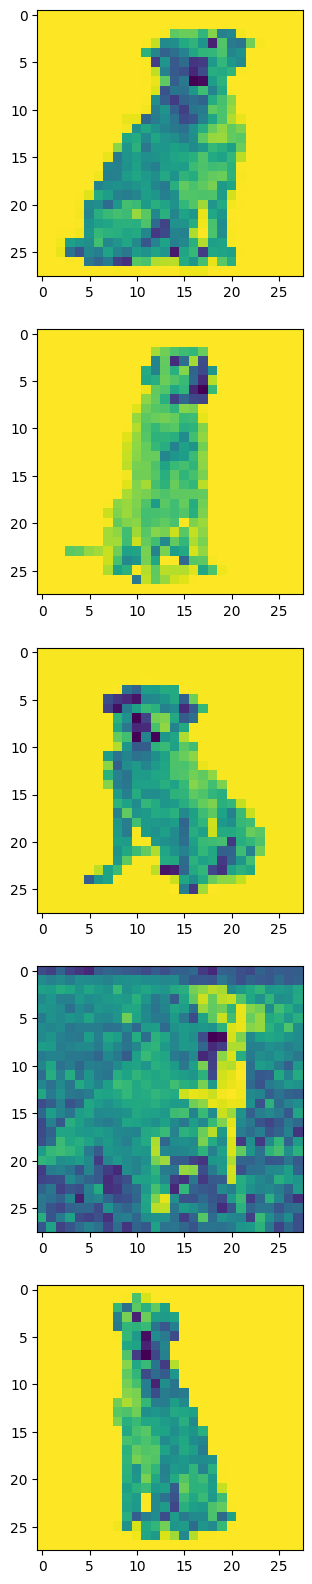

In [8]:
img_width = 28
img_height = 28

dim = (img_width, img_height)

doggos = [
    "./labrador1.jpg",
    "./labrador2.jpg",
    "./labrador3.jpg",
    "./labrador4.jpg",
    "./labrador5.jpg"
]

images = []

for doggo in doggos:
    img = cv2.imread(doggo, 0) / 255 # read as grayscale 1 channel images and normalize
    
    img = cv2.resize(img, dim)
    
    images.append(img)

num_images = len(images)
num_cols   = 1

col_names = [
    "Original"
]

fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(num_cols*4, num_images*4))
counter = 0

for img in images:
    counter += 1
    
    plt.subplot(len(images), num_cols, counter)
    plt.imshow(img)

In [9]:
data = []

for img in images:
    data.append(img.ravel())

x = torch.Tensor(np.array(data))

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [10]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "variational-autoencoder.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.04it/s, loss=1.67]


Ave Loss: 1.6163162469863892
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.92it/s, loss=0.788]


Ave Loss: 0.8985830187797547
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 155.46it/s, loss=0.565]


Ave Loss: 0.6702376008033752
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.98it/s, loss=0.437]


Ave Loss: 0.5622720181941986
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 173.36it/s, loss=0.463]


Ave Loss: 0.5322582960128784
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 120.96it/s, loss=0.372]


Ave Loss: 0.49019219875335696
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 178.28it/s, loss=0.43]


Ave Loss: 0.48756561279296873
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 192.16it/s, loss=0.317]


Ave Loss: 0.48507314920425415
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 152.11it/s, loss=0.265]


Ave Loss: 0.4388838350772858
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 138.93it/s, loss=0.299]


Ave Loss: 0.5576119363307953
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 165.63it/s, loss=0.336]


Ave Loss: 0.4457356631755829
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 110.05it/s, loss=0.306]


Ave Loss: 0.47501508593559266
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.32it/s, loss=0.273]


Ave Loss: 0.47141242027282715
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.09it/s, loss=0.315]


Ave Loss: 0.5138388693332672
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 181.90it/s, loss=0.355]


Ave Loss: 0.5222850441932678
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 161.73it/s, loss=0.273]


Ave Loss: 0.4322518765926361
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 165.34it/s, loss=0.314]


Ave Loss: 0.46148345470428465
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.16it/s, loss=0.286]


Ave Loss: 0.4556888997554779
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 164.90it/s, loss=0.346]


Ave Loss: 0.471751868724823
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 135.42it/s, loss=0.269]


Ave Loss: 0.45282918214797974
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 170.18it/s, loss=0.275]


Ave Loss: 0.4334899425506592
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 180.29it/s, loss=0.339]

Ave Loss: 0.4972484529018402
Epoch: 22



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.25it/s, loss=0.278]


Ave Loss: 0.43762914538383485
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.34it/s, loss=0.29]


Ave Loss: 0.42472302317619326
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.83it/s, loss=0.258]


Ave Loss: 0.4776737630367279
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 198.80it/s, loss=0.253]


Ave Loss: 0.4469395339488983
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.98it/s, loss=0.301]


Ave Loss: 0.427517294883728
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 195.42it/s, loss=0.263]


Ave Loss: 0.45939225554466245
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 169.34it/s, loss=0.274]


Ave Loss: 0.49238577485084534
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.99it/s, loss=0.29]


Ave Loss: 0.4600341558456421
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 182.46it/s, loss=0.298]


Ave Loss: 0.5592088818550109
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 138.58it/s, loss=0.299]


Ave Loss: 0.5037700235843658
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 142.20it/s, loss=0.364]


Ave Loss: 0.4945694893598557
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 170.80it/s, loss=0.284]


Ave Loss: 0.46893700659275056
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 178.74it/s, loss=0.329]


Ave Loss: 0.4676933467388153
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.27it/s, loss=0.322]


Ave Loss: 0.48909083008766174
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 147.58it/s, loss=0.318]


Ave Loss: 0.4371688306331635
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 187.27it/s, loss=0.315]


Ave Loss: 0.4514904946088791
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 219.06it/s, loss=0.28]


Ave Loss: 0.4701465904712677
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 205.72it/s, loss=0.376]


Ave Loss: 0.49525906443595885
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.44it/s, loss=0.333]


Ave Loss: 0.465784615278244
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.53it/s, loss=0.296]


Ave Loss: 0.43936374187469485
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 182.79it/s, loss=0.265]


Ave Loss: 0.45499429702758787
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 181.99it/s, loss=0.363]


Ave Loss: 0.44102540910243987
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.91it/s, loss=0.287]


Ave Loss: 0.45253169536590576
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.13it/s, loss=0.256]


Ave Loss: 0.4376103401184082
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 150.72it/s, loss=0.322]


Ave Loss: 0.45266705453395845
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 167.55it/s, loss=0.298]


Ave Loss: 0.4380065262317657
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 185.27it/s, loss=0.285]


Ave Loss: 0.46942865252494814
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 200.85it/s, loss=0.288]


Ave Loss: 0.46611504852771757
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 171.74it/s, loss=0.335]


Ave Loss: 0.47222726345062255
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 175.39it/s, loss=0.28]


Ave Loss: 0.46393024921417236
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.34it/s, loss=0.254]


Ave Loss: 0.44831464886665345
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 165.09it/s, loss=0.29]


Ave Loss: 0.449123215675354
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 182.14it/s, loss=0.25]


Ave Loss: 0.45597407817840574
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 150.94it/s, loss=0.315]


Ave Loss: 0.49155682921409605
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.69it/s, loss=0.374]


Ave Loss: 0.5075284957885742
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 164.71it/s, loss=0.292]


Ave Loss: 0.44005742073059084
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 177.89it/s, loss=0.312]


Ave Loss: 0.41319115161895753
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 180.61it/s, loss=0.244]


Ave Loss: 0.4278575301170349
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 175.04it/s, loss=0.299]


Ave Loss: 0.4183021724224091
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 139.12it/s, loss=0.337]


Ave Loss: 0.46396276354789734
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 156.54it/s, loss=0.233]


Ave Loss: 0.4022481620311737
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.12it/s, loss=0.257]


Ave Loss: 0.41368640065193174
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 157.25it/s, loss=0.335]


Ave Loss: 0.49758214950561525
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.36it/s, loss=0.258]


Ave Loss: 0.47843806743621825
Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 218.93it/s, loss=0.294]


Ave Loss: 0.5014737248420715
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 132.01it/s, loss=0.302]


Ave Loss: 0.45396021008491516
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.37it/s, loss=0.291]


Ave Loss: 0.4523085653781891
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 100.37it/s, loss=0.329]


Ave Loss: 0.5628793001174927
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 172.23it/s, loss=0.367]


Ave Loss: 0.4679765164852142
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 181.82it/s, loss=0.334]


Ave Loss: 0.5541940033435822
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 172.02it/s, loss=0.315]


Ave Loss: 0.46188769340515134
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 177.77it/s, loss=0.283]


Ave Loss: 0.4502130627632141
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.72it/s, loss=0.239]


Ave Loss: 0.4341987282037735
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 180.04it/s, loss=0.358]


Ave Loss: 0.44442529082298277
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 194.85it/s, loss=0.271]


Ave Loss: 0.40976282954216003
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 142.44it/s, loss=0.296]


Ave Loss: 0.4415985018014908
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 175.51it/s, loss=0.287]


Ave Loss: 0.4618611514568329
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 163.53it/s, loss=0.279]


Ave Loss: 0.5023276746273041
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 160.35it/s, loss=0.273]


Ave Loss: 0.4637480854988098
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.13it/s, loss=0.271]


Ave Loss: 0.42887113690376283
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 204.87it/s, loss=0.252]


Ave Loss: 0.4415680646896362
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 166.43it/s, loss=0.242]


Ave Loss: 0.49897217452526094
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 142.04it/s, loss=0.321]


Ave Loss: 0.46014204025268557
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 151.51it/s, loss=0.373]


Ave Loss: 0.41476610898971555
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.23it/s, loss=0.392]


Ave Loss: 0.48917784094810485
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 230.67it/s, loss=0.247]


Ave Loss: 0.5120146840810775
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 199.61it/s, loss=0.317]


Ave Loss: 0.45928473472595216
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 159.93it/s, loss=0.27]


Ave Loss: 0.44487968683242796
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.03it/s, loss=0.346]


Ave Loss: 0.41873725056648253
Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 175.30it/s, loss=0.341]


Ave Loss: 0.45183993577957154
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 196.75it/s, loss=0.373]


Ave Loss: 0.523332804441452
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 189.28it/s, loss=0.318]


Ave Loss: 0.4300374388694763
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 169.61it/s, loss=0.259]


Ave Loss: 0.4210308074951172
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 147.33it/s, loss=0.356]


Ave Loss: 0.5564775168895721
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 210.60it/s, loss=0.276]


Ave Loss: 0.454707932472229
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 187.59it/s, loss=0.322]


Ave Loss: 0.521202129125595
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.20it/s, loss=0.301]


Ave Loss: 0.5161779224872589
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 177.21it/s, loss=0.304]


Ave Loss: 0.4456415414810181


In [11]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

/tmp/ipykernel_531077/563129376.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])


torch.Size([1, 8])

In [12]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model.sample(sampled_mu, sampled_logvar)

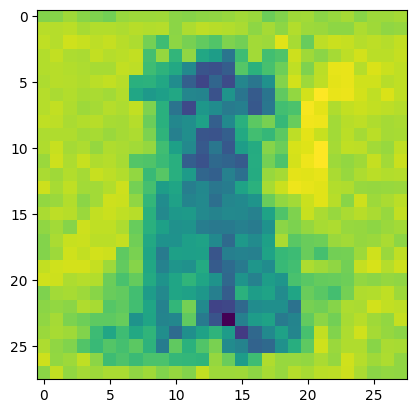

In [13]:
# Sample the first reconstructed sample
reconstructed_image = reconstruction[0].detach().cpu().numpy()
reconstructed_image = reconstructed_image.reshape(img_width, img_height)
plt.imshow(reconstructed_image)